In [14]:
from pyzbar import pyzbar
import cv2
import os
import numpy as np
import imutils
from matplotlib import pyplot as plt

In [15]:
def detect(image):
    # convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # compute the Scharr gradient magnitude representation of the images
    # in both the x and y direction using OpenCV 2.4
    ddepth = cv2.cv.CV_32F if imutils.is_cv2() else cv2.CV_32F
    gradX = cv2.Sobel(gray, ddepth=ddepth, dx=1, dy=0, ksize=-1)
    gradY = cv2.Sobel(gray, ddepth=ddepth, dx=0, dy=1, ksize=-1)

    # subtract the y-gradient from the x-gradient
    gradient = cv2.subtract(gradX, gradY)
    gradient = cv2.convertScaleAbs(gradient)

    # blur and threshold the image
    blurred = cv2.blur(gradient, (9, 9))
    (_, thresh) = cv2.threshold(blurred, 225, 255, cv2.THRESH_BINARY)

    # construct a closing kernel and apply it to the thresholded image
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (21, 7))
    closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

    # perform a series of erosions and dilations
    closed = cv2.erode(closed, None, iterations=4)
    closed = cv2.dilate(closed, None, iterations=4)

    # find the contours in the thresholded image
    cnts = cv2.findContours(closed.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)

    # if no contours were found, return None
    if len(cnts) == 0:
        return None

    # otherwise, sort the contours by area and compute the rotated
    # bounding box of the largest contour
    c = sorted(cnts, key=cv2.contourArea, reverse=True)[0]
    rect = cv2.minAreaRect(c)
    box = cv2.cv.BoxPoints(rect) if imutils.is_cv2() else cv2.boxPoints(rect)
    box = np.int0(box)

    # return the bounding box of the barcode
    return box

In [16]:
def image_resize(image, width = None, height = None, inter = cv2.INTER_AREA):
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = image.shape[:2]

    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image

    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # resize the image
    resized = cv2.resize(image, dim, interpolation = inter)

    # return the resized image
    return resized

In [40]:
def sharpen_img(image):
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]], np.float32) #锐化
    dst = cv2.filter2D(image, -1, kernel=kernel)
    return dst


(906, 680, 3)
Rect(left=601, top=408, width=0, height=0)
885091091285590148 (CODE128)
[[ 64 377]
 [ 61 232]
 [207 229]
 [210 375]]


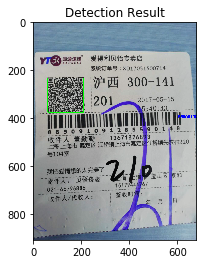

(906, 680, 3)
Rect(left=95, top=637, width=365, height=41)
883145685201074024 (CODE128)
[[336 338]
 [335 291]
 [548 285]
 [550 332]]


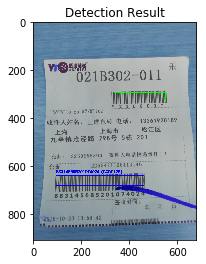

(906, 680, 3)
Rect(left=544, top=753, width=107, height=107)
302-011 803-883149563710509359 (QRCODE)
Rect(left=108, top=701, width=1, height=8)
883149563710509359 (CODE128)
[[381 710]
 [381 613]
 [407 613]
 [407 710]]


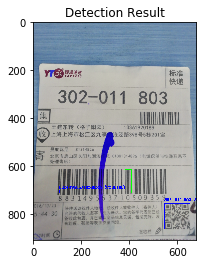

(906, 680, 3)
Rect(left=146, top=676, width=409, height=47)
883483693321275939 (CODE128)
[[558 718]
 [160 718]
 [160 681]
 [558 681]]


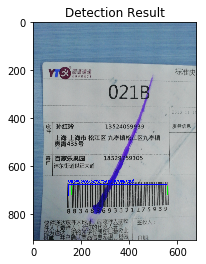

(906, 680, 3)
Rect(left=554, top=759, width=107, height=104)
302-011 803-883156610573757628 (QRCODE)
Rect(left=138, top=634, width=416, height=86)
883156610573757628 (CODE128)
[[534 444]
 [533 397]
 [602 396]
 [603 442]]


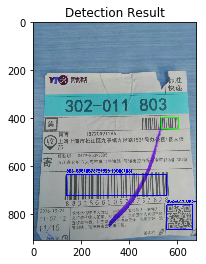

(906, 680, 3)
failed img: data/cc11df21d94ad065026b808dadd08d41.jpg
[[ 92 662]
 [ 91 597]
 [447 595]
 [448 660]]


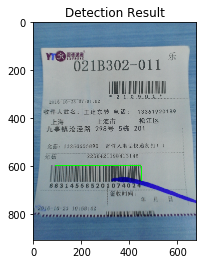

(906, 680, 3)
failed img: data/f693968b511178e86c84b0cb0575f563.jpg
[[ 95 721]
 [ 91 640]
 [485 624]
 [488 705]]


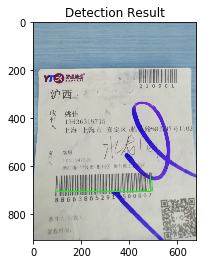

(906, 680, 3)
Rect(left=98, top=365, width=500, height=46)
886640137817264936 (CODE128)
[[479 831]
 [477 798]
 [677 783]
 [679 817]]


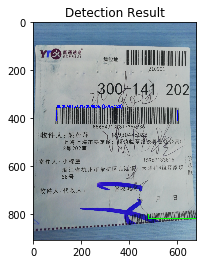

(906, 680, 3)
Rect(left=108, top=379, width=1, height=10)
883433655637091461 (CODE128)
[[106 444]
 [104 371]
 [485 363]
 [487 436]]


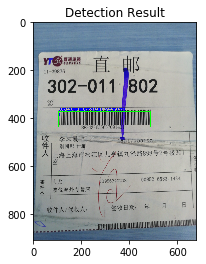

(906, 680, 3)
failed img: data/dea01e91c06b9bb13de2330534d2d727.jpg
[[133 249]
 [133 224]
 [192 224]
 [192 249]]


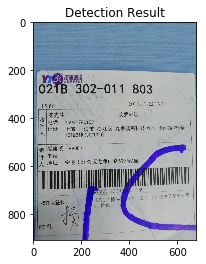

Spend 5.775719165802002 seconds and failed 3


In [43]:
import time
images = ["01aab9aeaa3036c7d1aa06c2cdac6d86.jpg",
          "6f62d72b1edd3725efdc162d308c7efd.jpg",
          "f53a0f0d514213daa6c4a531c4304a82.jpg",
          "0466eabbc7ba29627426dff8957e2310.jpg",
          "7f993bbb4972a017440077aad5fc8cae.jpg",
          "cc11df21d94ad065026b808dadd08d41.jpg",
          "f693968b511178e86c84b0cb0575f563.jpg",
          "55f148e84e399bc8722dce6c02473851.jpg",
          "a50abe301c4aee444bd8cbfa86028c8c.jpg",
          "dea01e91c06b9bb13de2330534d2d727.jpg"]
failed_num = 0
start_time = time.time()
for image_name in images:
    image_path = os.path.join("data", image_name)
    image = cv2.imread(image_path)
    hard_limit_high = 1067
    hard_limit_width = 680
    #resize image
    
    if image.shape[1] > hard_limit_width:
        image = image_resize(image, width=hard_limit_width)
    '''
    if image.shape[0] > hard_limit_high:
        image = image_resize(image, height=hard_limit_high)
    '''
    print(image.shape)
    #image = sharpen_img(image)
    # find the barcodes in the image and decode each of the barcodes
    barcodes = pyzbar.decode(image)

    # loop over the detected barcodes
    find_flag = False
    for barcode in barcodes:
        barcodeData = barcode.data.decode("utf-8")
        barcodeType = barcode.type
        if barcodeData.find("88") >= 0:
            # extract the bounding box location of the barcode and draw the
            # bounding box surrounding the barcode on the image
            (x, y, w, h) = barcode.rect
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 0, 255), 2)

            # the barcode data is a bytes object so if we want to draw it on
            # our output image we need to convert it to a string first
            

            # draw the barcode data and barcode type on the image
            text = "{} ({})".format(barcodeData, barcodeType)
            cv2.putText(image, text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
            print(barcode.rect)
            print(text)
            find_flag = True
    if not find_flag:
        failed_num += 1
        print("failed img: {}".format(image_path))
    box = detect(image)
    print(box)
    cv2.rectangle(image, tuple(box[1]), tuple(box[3]), (0, 255, 0), 2)
    # show the output image
    #plt.rcParams["figure.figsize"] = (image.shape[0],image.shape[1])
    plt.imshow(image)
    plt.title('Detection Result')
    plt.show()
    cv2.imwrite("data/output.png", image)
end_time = time.time()
print("Spend {} seconds and failed {}".format(end_time-start_time, failed_num))
